# NCP Model
This script will oad the data compilation file (ship.data) and then setup and run the NCP model. Finally, it will produce graphs and plots based on NCP and the cycle/transect/stations.

In [52]:
## Install the package if needed:
#install.packages('Mcomp', repos='http://cran.us.r-project.org')
#library(R.matlab)  # If you need to read in matlab .mat files
library(openxlsx)  # If you need to read in .xlsx files


## Moving Average function (for smoothing)
ma <- function(x, n=5){
    filter(x,rep(1/n,n), sides=2)
}

## Helper function for converting the date time stamps.
conv_excel_time = function(x, tz='US/Pacific') {
    as.POSIXct(as.Date(x,origin="1899-12-30", tz=tz))
}

get.pal = function(x, n=100) {
    rbPal(n)[as.numeric(cut(x, breaks = n))]
}

In [53]:
# Load the data
load(file='./RStates/ship.final.rdata')

## Verify the loaded data
ship.data = ship.data[!is.na(ship.data$LO), ]
ship.data = ship.data[!is.na(ship.data$Cycle), ]
str(ship.data)

'data.frame':	4170 obs. of  28 variables:
 $ DT            : POSIXct, format: "2017-05-30 20:01:00" "2017-05-30 20:11:00" ...
 $ TW            : num  2.91 2.83 3.12 2.5 2.12 ...
 $ TI            : num  220 205 195 178 172 ...
 $ TT            : num  19.4 19.4 19.4 19.4 19.4 ...
 $ SA            : num  33.2 33.2 33.2 33.2 33.2 ...
 $ OS            : num  5 5 4.99 4.99 4.98 ...
 $ FL            : num  0.0722 0.0705 0.0735 0.0796 0.0861 ...
 $ AT            : num  16.7 16.7 16.6 16.2 16.4 ...
 $ BP            : num  1010 1010 1010 1010 1010 ...
 $ PA            : num  896 871 713 588 716 ...
 $ SA.1          : num  33.2 33.2 33.2 33.2 33.2 ...
 $ OS.1          : num  5 5 4.99 4.99 4.98 ...
 $ FL.1          : num  0.0722 0.0705 0.0735 0.0796 0.0861 ...
 $ LA            : num  32.7 32.7 32.7 32.7 32.7 ...
 $ LO            : num  -117 -117 -117 -117 -117 ...
 $ NCEP          : num  1.89 1.94 1.99 2.04 2.09 ...
 $ NCEP.5        : num  3.17 3.17 3.17 3.17 3.17 ...
 $ TW.5          : num  NaN 2

In [54]:
O2sol = function(S, T) {
    # convert T to scaled temperature
    temp_S = log((298.15 - T) / (273.15 + T))

    # constants from Table 1 of Garcia & Gordon for the fit to Benson and Krause (1984)
    A0_o2 = 5.80871
    A1_o2 = 3.20291
    A2_o2 = 4.17887
    A3_o2 = 5.10006
    A4_o2 = -9.86643e-2
    A5_o2 = 3.80369
    B0_o2 = -7.01577e-3
    B1_o2 = -7.70028e-3
    B2_o2 = -1.13864e-2
    B3_o2 = -9.51519e-3
    C0_o2 = -2.75915e-7

    # Corrected Eqn (8) of Garcia and Gordon 1992 (umol / kg)
    exp(A0_o2 + A1_o2*temp_S + A2_o2*temp_S^2 + A3_o2*temp_S^3 + A4_o2*temp_S^4 + A5_o2*temp_S^5 + 
        S*(B0_o2 + B1_o2*temp_S +B2_o2*temp_S^2 + B3_o2*temp_S^3) + C0_o2*S^2)
}

# NCP Calculation

In [55]:
# NCP in mmol m-2 d-1; seawater density in kg m-3, O2sol in microL kg-1
#ncp = (ship.data$O2.Ar/100) * (O2sol(ship.data$SA, ship.data$TT) / 1000) * ship.data$sw_dens0(salt, temp) * wpv;

ship.data$NCP = 0
ship.data$NCP = (ship.data$O2.Ar/ship.data$O2.Ar.cal - 1) * (O2sol(ship.data$SA, ship.data$TT) / 1000) * 1030 * ship.data$k

# Preliminary Review

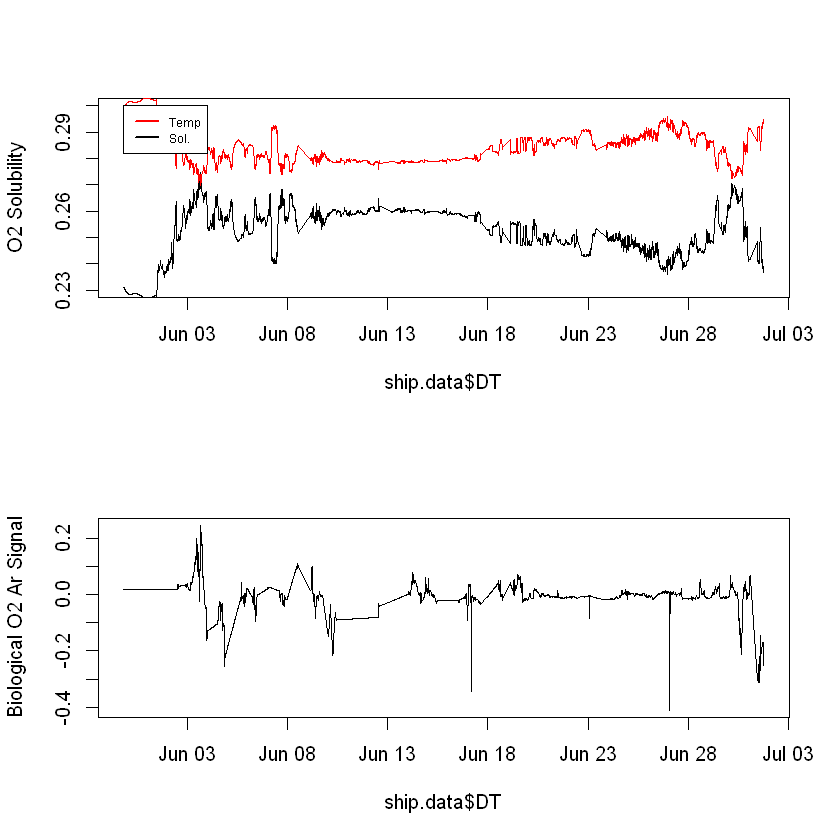

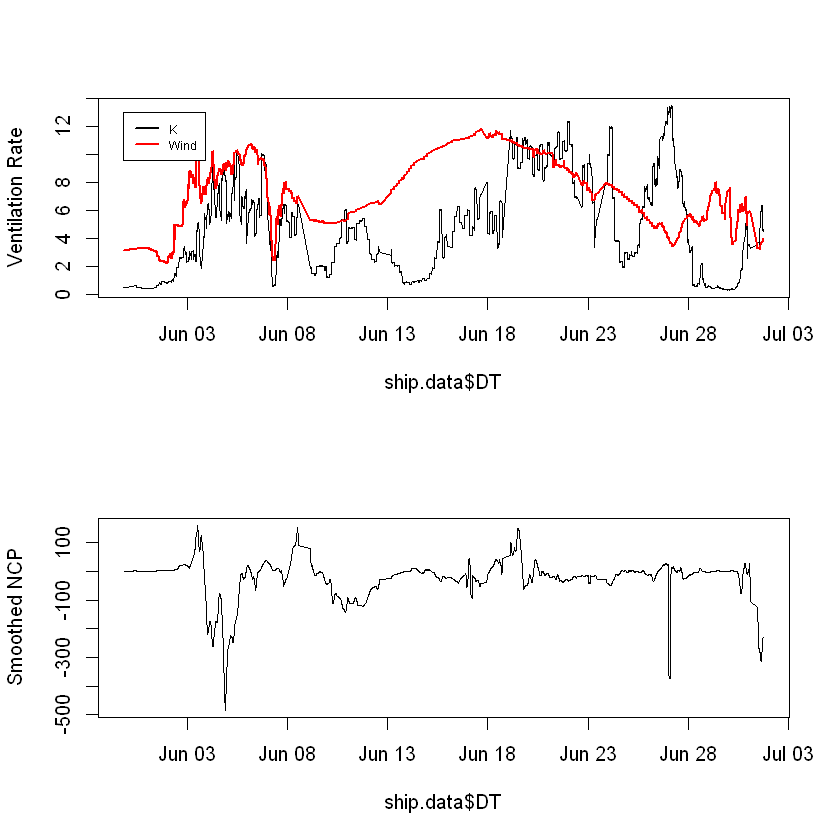

In [59]:
#pdf('Output/NCP Diagnostics.pdf')

par(mfrow=c(2,1))

## O2 solubility and temperature
plot(ship.data$DT, O2sol(ship.data$SA, ship.data$TT) / 1000, type='l', ylab='O2 Solubility', ylim=c(0.23, 0.30))
lines(ship.data$DT, ship.data$TT/300 + 0.235, col='red', lwd=1)
legend(ship.data$DT[1], 0.30, c('Temp', 'Sol.'), col=c('red', 'black'), cex=0.6, lwd=2)

## Biological O2 argon singal
plot(ship.data$DT,  (ship.data$O2.Ar / ship.data$O2.Ar.cal - 1), type='l', ylab='Biological O2 Ar Signal')

## Wind speed and k values
plot(ship.data$DT, ship.data$k, type='l', ylab='Ventilation Rate')
lines(ship.data$DT, ship.data$NCEP.5, col='red', lwd=2)
legend(ship.data$DT[1], 13, c('K', 'Wind'), col=c('black', 'red'), cex=0.6, lwd=2)

## NCP plot (smoothed)
plot(ship.data$DT, ma(ship.data$NCP, 15), type='l', ylab='Smoothed NCP')

#dev.off()

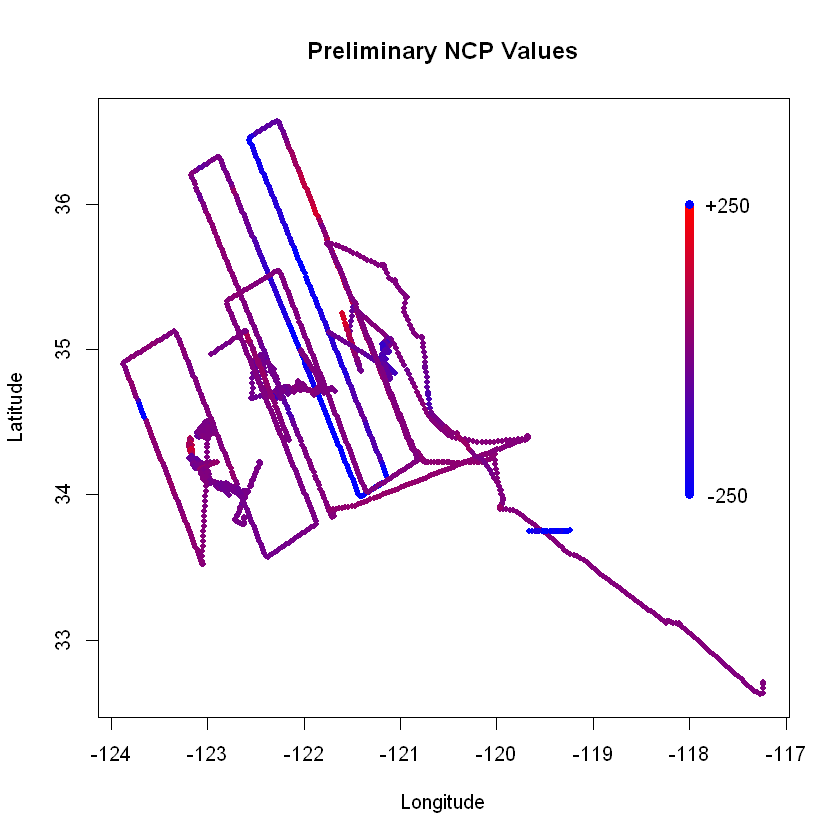

In [67]:
#pdf('Output/Spatial NCP.pdf')
rbPal <- colorRampPalette(c('blue', 'red'))

#This adds a column of color values
# based on the y values
ncp2 = ship.data$NCP
ncp2[ncp2 < -250] = -250
ncp2[ncp2 > 250] = 250

col <- get.pal(ncp2)

plot(ship.data$LO, ship.data$LA, pch = 20, col = col, main='Preliminary NCP Values', ylab='Latitude', xlab='Longitude')

## Legend
points(x = rep(-118, 101), y = seq(34, 36, 1/50), col=rbPal(100), pch=16)
text(-117.6, 36, '+250')
text(-117.6, 34, '-250')

#dev.off()

# Cycles Analysis

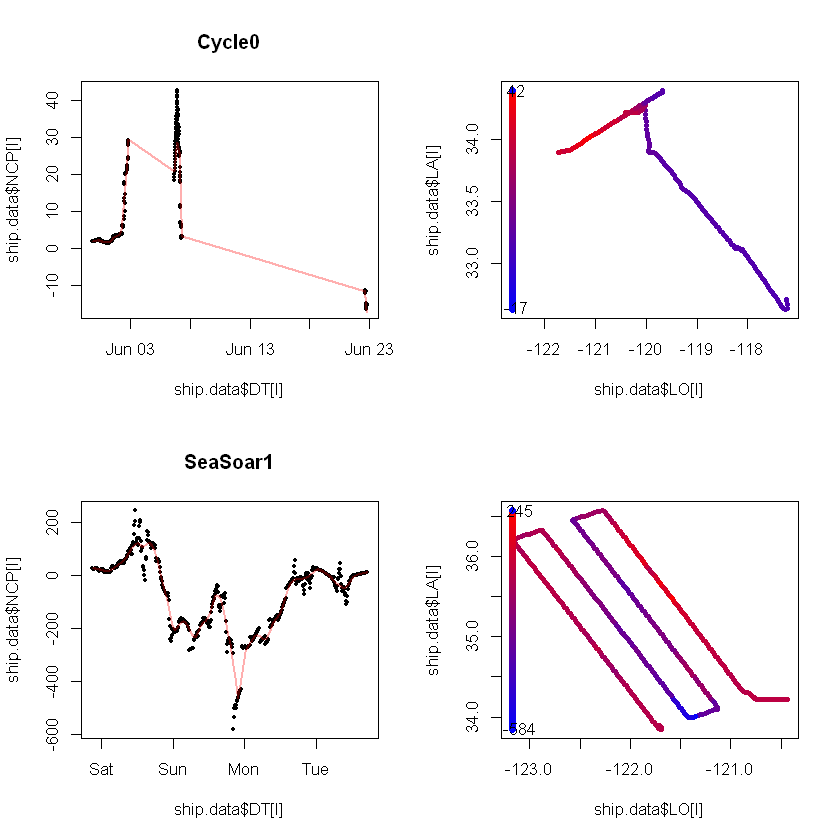

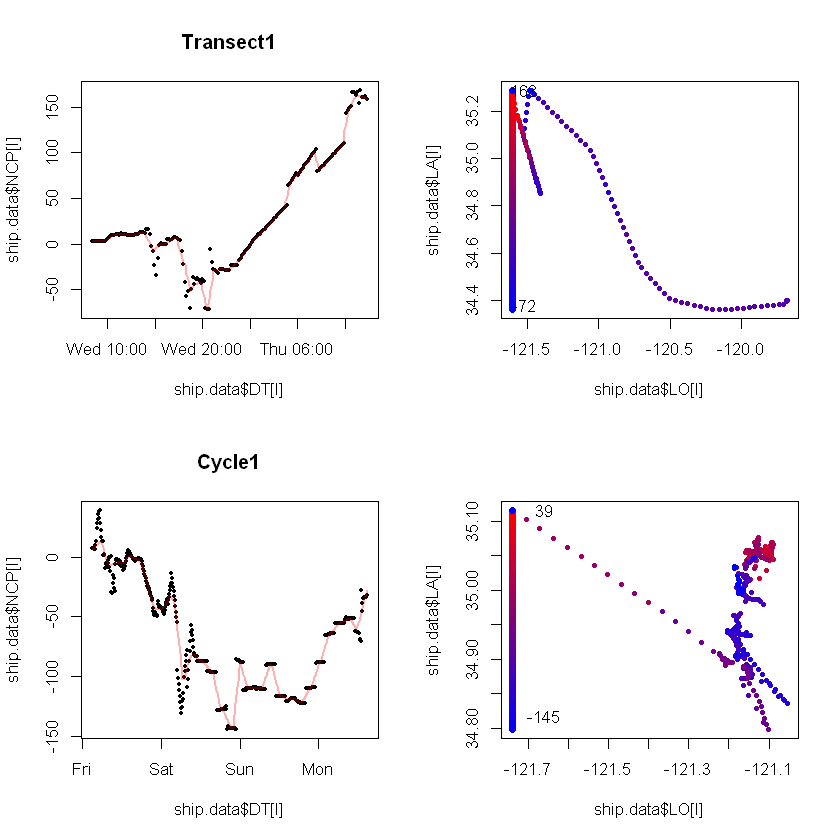

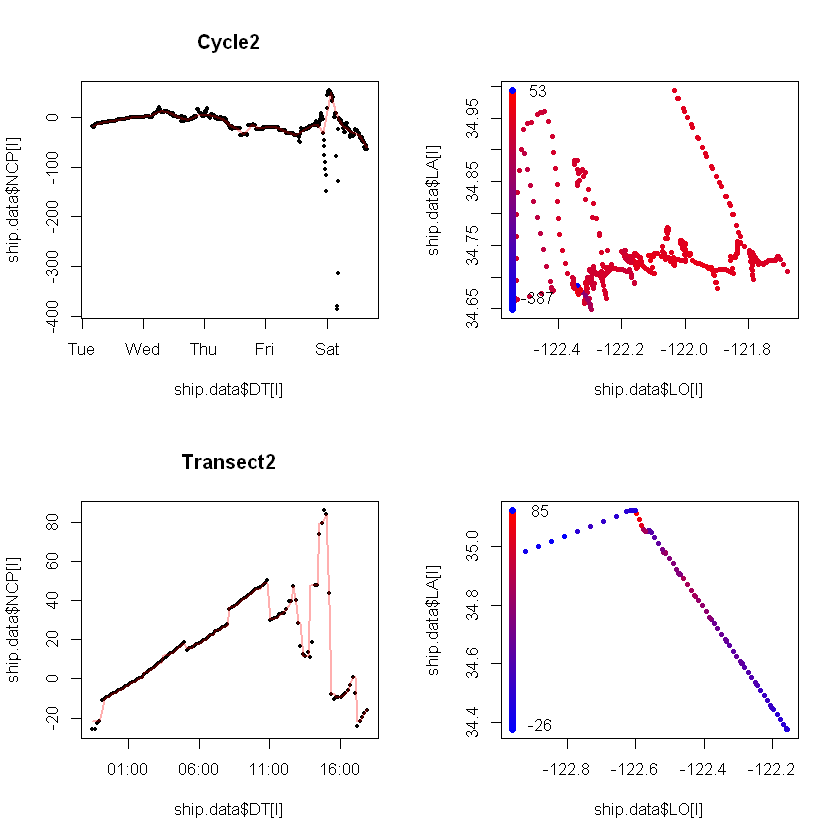

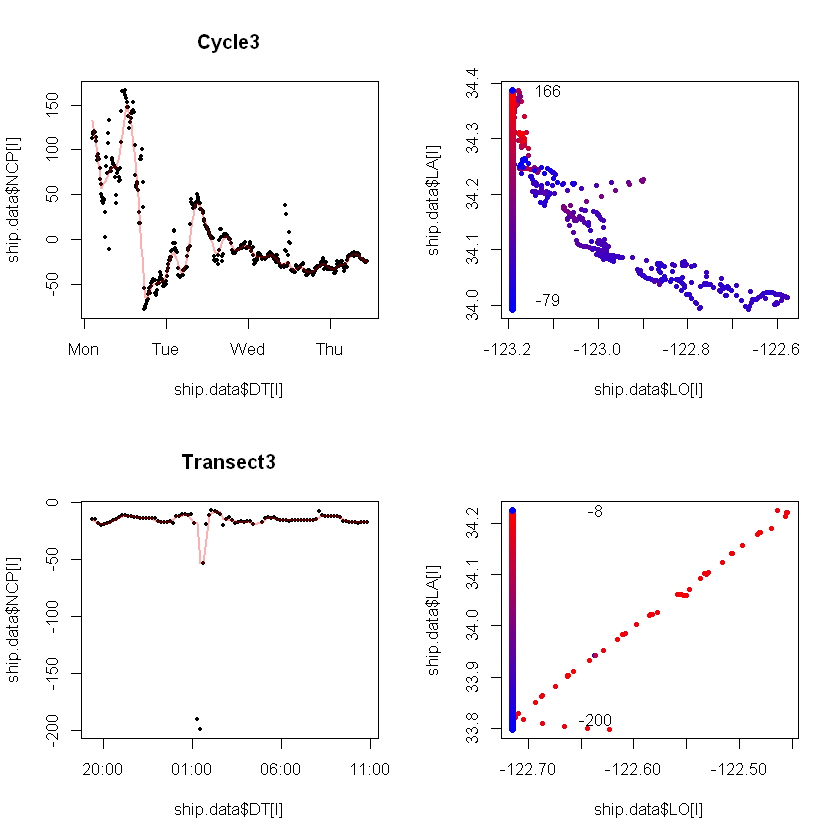

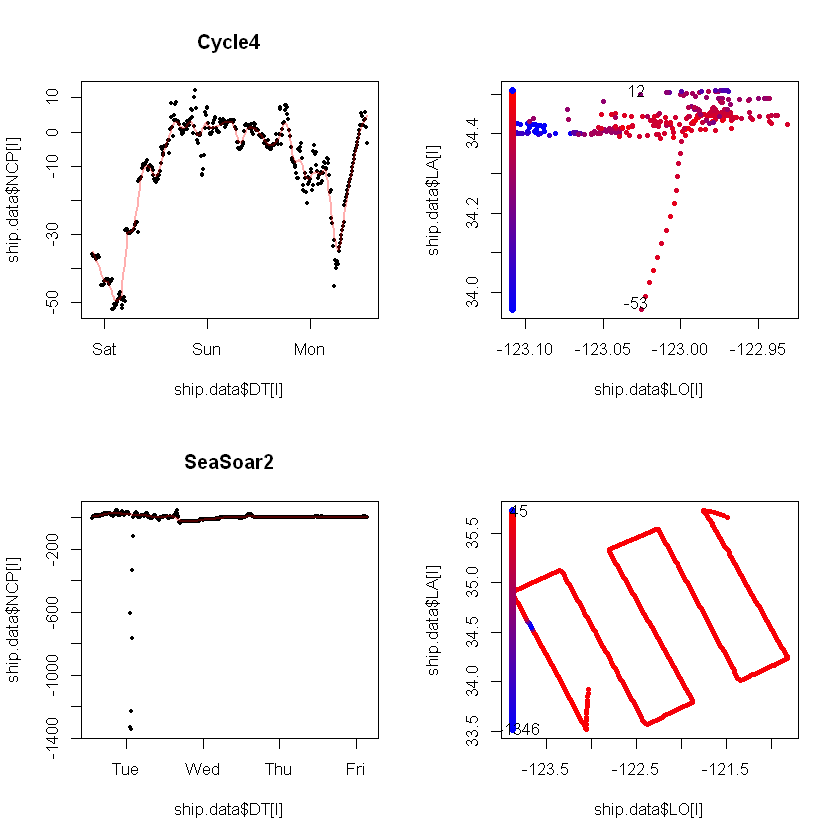

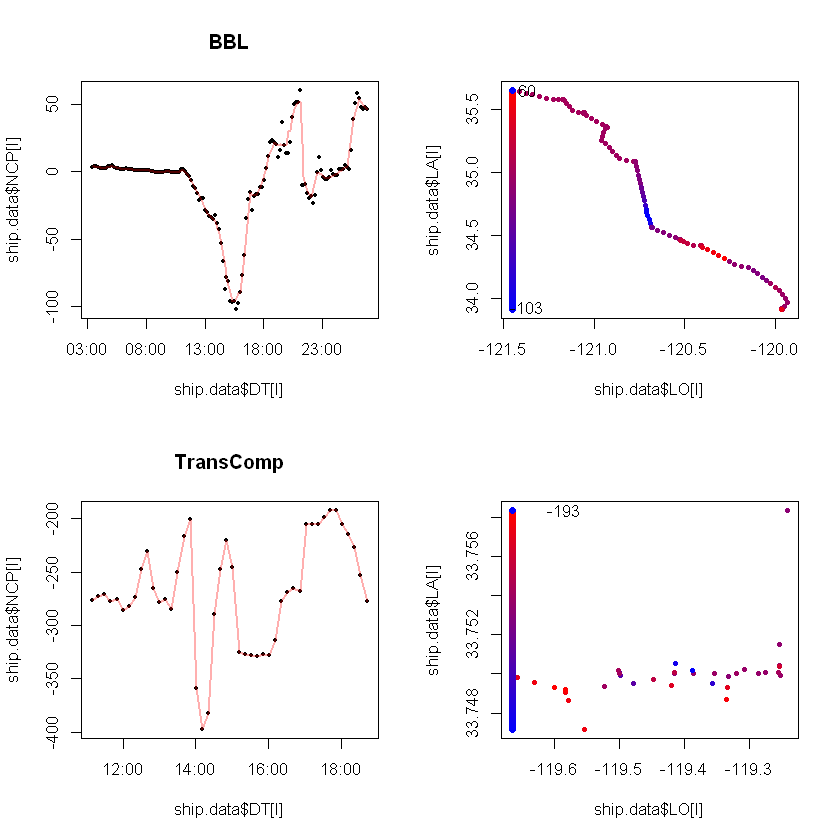

In [83]:
#pdf('Output/NCP Cycles Preliminary.pdf')
par(mfrow=c(2,2))

for (i in unique(ship.data$Cycle)) {
    l = which(ship.data$Cycle == i)
    l = l[ship.data$NCP[l] > -10000 & ship.data$NCP[l] < 10000]
    
    col = get.pal(ship.data$NCP[l])
    
    mod = lowess(x = ship.data$DT[l], ship.data$NCP[l], f = 0.05)
    plot(ship.data$DT[l], ship.data$NCP[l], main=i, pch=16, cex=0.5, lwd=2)
    lines(mod, col='#ff000050', lwd=2)
    
    plot(ship.data$LO[l], ship.data$LA[l], pch=20, col=col)
    points(x = rep(min(ship.data$LO[l]), 101), y = seq(min(ship.data$LA[l]), max(ship.data$LA[l]), length.out=101),
           col=rbPal(100), pch=16)
    text(min(ship.data$LO[l])+0.08, max(ship.data$LA[l]), floor(max(ship.data$NCP[l])))
    text(min(ship.data$LO[l])+0.08, min(ship.data$LA[l])+0.02, floor(min(ship.data$NCP[l])))
}
#dev.off()